# Pk Emulator

## PCA+InterPol Method

In [1]:
import scipy
import pyccl as ccl
import numpy as np
import pylab as plt
import itertools

import pymaster as nmt
from numpy import linalg
from sklearn.decomposition import PCA

import lin_pk_emul as emul

In [2]:
emulator_100 = emul.LinPkEmulator(10, 200, 100, new=True)
emulator_20 = emul.LinPkEmulator(10, 200, 20, new=False)
emulator_10 = emul.LinPkEmulator(10, 200, 10, new=False)
emulator_200 = emul.LinPkEmulator(10, 200, 200, new=False)

In [3]:
k_arr, emulated_100 = emulator_100.get_emulated_Pk(0.27,0.67)
k_arr, emulated_20 = emulator_20.get_emulated_Pk(0.27,0.67)
k_arr, emulated_10 = emulator_10.get_emulated_Pk(0.27,0.67)
k_arr, emulated_200 = emulator_200.get_emulated_Pk(0.27,0.67)
emulated_100 = np.exp(emulated_100)
emulated_20 = np.exp(emulated_20)
emulated_10 = np.exp(emulated_10)
emulated_200 = np.exp(emulated_200)

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:231: ComplexWarning: Casting complex values to real discards the imaginary part
  nx, tx, ny, ty, c, fp, ier = dfitpack.regrid_smth(


In [4]:
evecs = emulator_10.get_evecs();
emulator_200.get_evecs();
emulator_20.get_evecs();
emulator_100.get_evecs();

In [13]:
 emulated_100.real

array([4.25595452e+02, 4.73956421e+02, 5.27812723e+02, 5.87788771e+02,
       6.54579984e+02, 7.28960731e+02, 8.11793489e+02, 9.04038617e+02,
       1.00676573e+03, 1.12116592e+03, 1.24856547e+03, 1.39044163e+03,
       1.54843921e+03, 1.72439040e+03, 1.92033523e+03, 2.13853465e+03,
       2.38145886e+03, 2.65187630e+03, 2.95286213e+03, 3.28781528e+03,
       3.66049709e+03, 4.07506604e+03, 4.53608883e+03, 5.04859472e+03,
       5.61810831e+03, 6.25064589e+03, 6.95277493e+03, 7.73164734e+03,
       8.59495911e+03, 9.55101323e+03, 1.06087250e+04, 1.17774692e+04,
       1.30671639e+04, 1.44881716e+04, 1.60509116e+04, 1.77659566e+04,
       1.96437650e+04, 2.16939551e+04, 2.39253711e+04, 2.63455395e+04,
       2.89594799e+04, 3.17697576e+04, 3.47754815e+04, 3.79704306e+04,
       4.13432939e+04, 4.48761243e+04, 4.85424049e+04, 5.23063504e+04,
       5.61213182e+04, 5.99284151e+04, 6.36550661e+04, 6.72138757e+04,
       7.05018064e+04, 7.34000191e+04, 7.57750597e+04, 7.74821931e+04,
      

In [6]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
theory  = ccl.power.linear_matter_power(cosmo, k_arr, 1)

In [7]:
Pk_diff_100 = abs(emulated_100 -theory)
Pk_diff_20 = abs(emulated_20 -theory)
Pk_diff_10 = abs(emulated_10 -theory)
Pk_diff_200  = abs(emulated_200  -theory)

In [8]:
evecs = np.transpose(evecs)

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


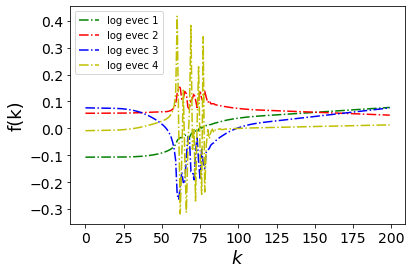

In [9]:
plt.plot(  evecs[0] , 'g-.', label = 'log evec 1' )
plt.plot(  evecs[1] , 'r-.', label = 'log evec 2' )
plt.plot(  evecs[2] , 'b-.', label = 'log evec 3' )
plt.plot(  evecs[3] , 'y-.', label = 'log evec 4' )

plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


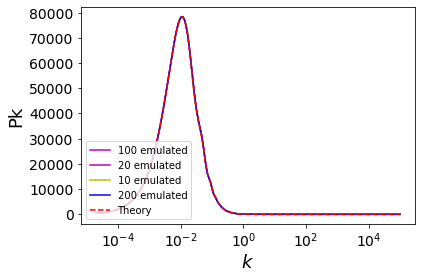

In [10]:
plt.plot(k_arr, emulated_100 , 'm-', label = '100 emulated' )
plt.plot(k_arr, emulated_20 , 'm-', label = '20 emulated' )
plt.plot(k_arr, emulated_10 , 'y-', label = '10 emulated' )
plt.plot(k_arr, emulated_200 , 'b-', label = '200 emulated' )
plt.plot(k_arr, theory, 'r--', label = 'Theory' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Pk',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

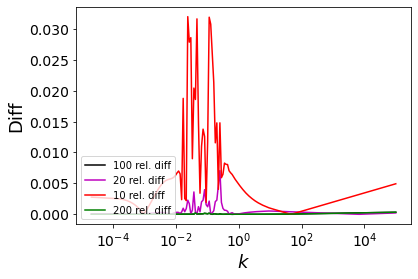

In [11]:
plt.plot(k_arr, Pk_diff_100/theory, 'k-', label = '100 rel. diff' )
plt.plot(k_arr, Pk_diff_20/theory, 'm-', label = '20 rel. diff' )
plt.plot(k_arr, Pk_diff_10/theory, 'r-', label = '10 rel. diff' )
plt.plot(k_arr, Pk_diff_200/theory, 'g-', label = '200 rel. diff' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Diff',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

In [13]:
def GoF(emulator, h_in, w_c_in):
    k, Pk_f = emulator.get_emulated_Pk(w_c_in, h_in)
    Pk_f = np.exp(Pk_f)
    
    cosmo = ccl.Cosmology(Omega_c=w_c_in, Omega_b=0.049, h=h_in, sigma8=0.81, n_s=0.96)
    Pk_t = ccl.power.linear_matter_power(cosmo, k, 1)
    
    N = np.sum(k**3)
    rel_diff = abs(Pk_t-Pk_f)/Pk_t
    D =np.sum(k**3*rel_diff**2)
    #print(D, rel_diff, N)
    
    return max(rel_diff), np.sqrt(D/N)

In [14]:
def dummy(emulator, h_in, w_c_in):
    k = np.logspace(-4.7,5, 200)
    cosmo = ccl.Cosmology(Omega_c=w_c_in, Omega_b=0.049, h=h_in, sigma8=0.81, n_s=0.96)
    Pk_t = ccl.power.linear_matter_power(cosmo, k, 1)
    
    return [1,1]

In [15]:
samples = 100
h_smp = 0.6 + (0.9-0.6)*np.random.rand(samples)
wc_smp = 0.01 + (1-0.01)*np.random.rand(samples)

In [16]:
%%time
gof_7= []
max_diff_arr_7= []
for i in range(samples):
    out = dummy(None, h_smp[i], wc_smp[i])
    gof_7.append(out[1])
    max_diff_arr_7.append(out[0])
gof_7 = np.array(gof_7) 
max_diff_arr_7 = np.array(max_diff_arr_7)
print(np.median(gof_7))
print(np.median(max_diff_arr_7))

1.0
1.0
CPU times: user 4min 32s, sys: 766 ms, total: 4min 33s
Wall time: 27.7 s


In [17]:
%%time
gof_10= []
max_diff_arr_10= []
for i in range(samples):
    out = GoF(emulator_10, h_smp[i], wc_smp[i])
    gof_10.append(out[1])
    max_diff_arr_10.append(out[0])
gof_10 = np.array(gof_10) 
max_diff_arr_10 = np.array(max_diff_arr_10)
print(np.median(gof_10))
print(np.median(max_diff_arr_10))

0.004038068968131098
0.03504017837072105
CPU times: user 4min 55s, sys: 1.03 s, total: 4min 56s
Wall time: 30.7 s


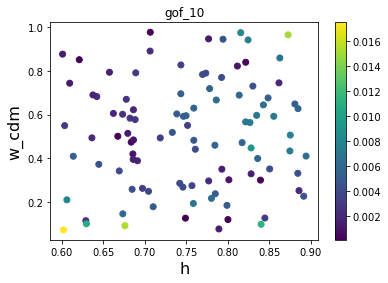

In [18]:
plt.scatter(h_smp, wc_smp, c = gof_10)
plt.title('gof_10')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

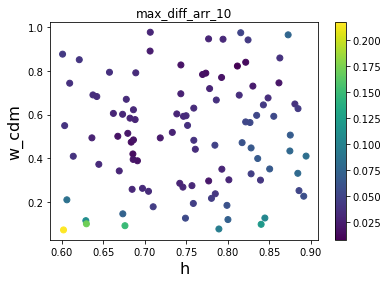

In [19]:
plt.scatter(h_smp, wc_smp, c = max_diff_arr_10)
plt.title('max_diff_arr_10')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

In [20]:
%%time
gof_20= []
max_diff_arr_20= []
for i in range(samples):
    out = GoF(emulator_20, h_smp[i], wc_smp[i])
    gof_20.append(out[1])
    max_diff_arr_20.append(out[0])
gof_20 = np.array(gof_20) 
max_diff_arr_20 = np.array(max_diff_arr_20)
print(np.median(gof_20))
print(np.median(max_diff_arr_20))

0.00033738551952523587
0.005189660101121799
CPU times: user 4min 52s, sys: 891 ms, total: 4min 53s
Wall time: 29.6 s


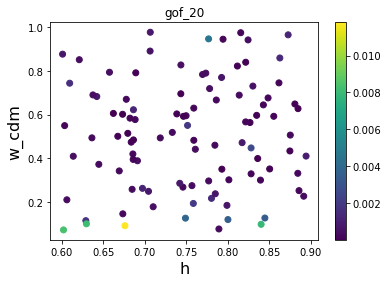

In [21]:
plt.scatter(h_smp, wc_smp, c = gof_20)
plt.title('gof_20')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

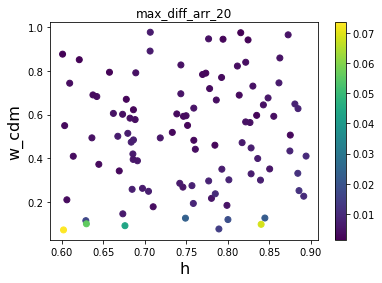

In [22]:
plt.scatter(h_smp, wc_smp, c = max_diff_arr_20)
plt.title('max_diff_arr_20')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

In [23]:
%%time
gof_100= []
max_diff_arr_100= []
for i in range(samples):
    out = GoF(emulator_100, h_smp[i], wc_smp[i])
    gof_100.append(out[1])
    max_diff_arr_100.append(out[0])
gof_100 = np.array(gof_100) 
max_diff_arr_100 = np.array(max_diff_arr_100)
print(np.median(gof_100))
print(np.median(max_diff_arr_100))

0.00017889351364545463
0.000278397253758229
CPU times: user 4min 43s, sys: 46.9 ms, total: 4min 43s
Wall time: 28.4 s


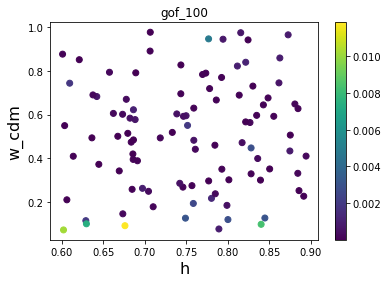

In [24]:
plt.scatter(h_smp, wc_smp, c = gof_100)
plt.title('gof_100')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

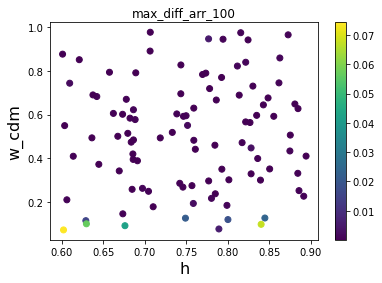

In [25]:
plt.scatter(h_smp, wc_smp, c = max_diff_arr_100)
plt.title('max_diff_arr_100')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

In [26]:
%%time
gof_200= []
max_diff_arr_200= []
for i in range(samples):
    out = GoF(emulator_200, h_smp[i], wc_smp[i])
    gof_200.append(out[1])
    max_diff_arr_200.append(out[0])
gof_200 = np.array(gof_200) 
max_diff_arr_200 = np.array(max_diff_arr_200)
print(np.median(gof_200))
print(np.median(max_diff_arr_200))

0.0001789208120892279
0.000278420877885505
CPU times: user 4min 40s, sys: 188 ms, total: 4min 40s
Wall time: 28.4 s


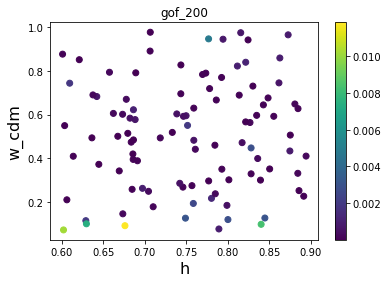

In [27]:
plt.scatter(h_smp, wc_smp, c = gof_200)
plt.title('gof_200')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()

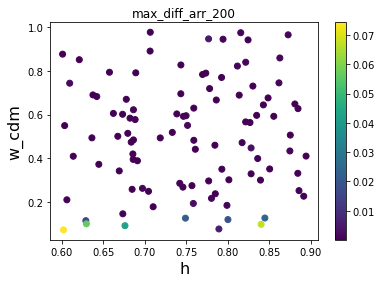

In [28]:
plt.scatter(h_smp, wc_smp, c = max_diff_arr_200)
plt.title('max_diff_arr_200')
plt.xlabel('h', fontsize=16)
plt.ylabel('w_cdm', fontsize=16)
plt.colorbar()
plt.show()